# The Evolution of Popular Music
By Niko Gupta and Joel Miller

### Table of Contents
TODO like in tutorial
* [Introduction](#Introduction)
* [Data Collection](#Data-Collection-and-Cleaning)
    * [Getting Spotify Features](#Getting-Spotify-Data)
* [Analysis](#Analysis)
    * [Hot 100 Feature Breakdown](#Hot-100-Feature-Breakdown)
    * [Genre Consistency](#Genre-Consistency)
    * [Genre Distribution in Hot 100](#Genre-Distribution-in-Hot-100)
    * [Top Songs of All Time](#Top-Songs-of-All-Time)
    * [Time Spent in Hot 100](#Time-Spent-in-Hot-100)
    * [Conclusions](#Analysis-Conclusions)
* [ML Model](#Machine-Learning-Model)
- ML benchmarking and conclusions
- links for further reading
- ideas for future research
    * demographic breakdown?
    * do it for not just the USA

## Introduction
This project has two primary goals.

First, we aim to identify trends in popular music over the past two decades. In particular, we would like to see how features of songs have evolved over time both within the top 100 songs in the USA and within top genres. We are also interested in seeing how the popularity of different genres has evolved over time.

This information could be useful for two reasons. First, it is interesting from a purely curiosity perspective. As somebody who loves listening to music, it's fascinating to see how music evolves over time. Secondly, historical trends are an excellent indicator of future trends. Knowing how music has been evolving can help music executives such as record labels better identify music that might be popular in the future, and market appropriately to their audiences.

To tackle this problem, we pull historical data from the [Billboard 100](https://www.billboard.com/charts/hot-100) to identify top songs in the USA, both generally and for specific genres. We then use the [spotify developer api](https://developer.spotify.com/) to search for the songs and identify song features. Using this information, we identify interesting trends and draw conclusions about the evolution of music.

Second, we train a model based on the above data that can predict the time period in which a song is most likely to have been popular, using features of that song. Outside of being an interesting problem to solve, this can be useful when recommending songs. If somebody likes a specific type of song, it's likely they would also like other songs that were popular around the same time as that song would have been popular.

## Data Collection and Cleaning
The first task at hand is to collect the top 100 songs for the last years. This can be accomplished by using the billboard 100 API, and then saving the dataset.

In [1]:
import billboard as bb
import pickle
import time
import os
from os.path import isfile, join

In [2]:
def get_charts(genre='hot-100'):
    allCharts = []

    # get latest chart
    chart = bb.ChartData(genre)
    new = True
    prevYear = chart.date.split('-')[0]

    # songs thru 2000
    while chart.date > '1999-12-31':
        # add week to list if new chart
        if new:
            currYear = chart.date.split('-')[0]

            # checkpoint at the end of each year
            if currYear != prevYear:
                with open(genre + prevYear, 'wb') as f:
                    pickle.dump(allCharts, f)
                    print("Checkpoint for Year: " + prevYear)
                prevYear = currYear
                allCharts = []

            # add week's songs to the list
            songs = []
            for song in chart.entries:
                songs.append({"name": song.title, "artist": song.artist, "date": chart.date})

            allCharts.append(songs)

        # wait 5 seconds and try to get another chart to avoid overwhleming billboard servers
        time.sleep(5)
        print(chart.date)
        try:
            # try to get previous week's chart, if this is last chart, break
            if not chart.previousDate:
                break
            chart = bb.ChartData(genre, chart.previousDate)
            new = True
        except Exception as e:
            # if fail from connection loss or too many requests, ignore and try again
            print(type(e))
            new = False

    # save out last chart
    with open(genre + prevYear, 'wb') as f:
        pickle.dump(allCharts, f)
        print("Checkpoint for Year: " + prevYear)

Now that we can get data for any genre, we need to get it for each genre we're interested in. One issue to note is that given 20 years, 52 weeks per year, and 5 seconds per request, we get about 86 minutes per genre. If we want to collect data for the hot-100 plus 8 other genres as below, this could take nearly 13 hours! In addition, we can't run this function in 9 different processes, because the billboard API rate limits based on source IP (as opposed to using an authentication token). To get around this, we ran this script on 9 different VMs, allowing us to collect the data in under two hours.

In [3]:
genres = {'hot-100',
          'pop-songs',
          'country-songs',
          'rock-songs',
          'alternative-songs',
          'r-b-hip-hop-songs',
          'dance-electronic-songs',
          'christian-songs',
          'jazz-songs'}

def getHandles(f):
    return open(f, 'rb')
    
def combine_charts(chart):
    chart_files = [f for f in os.listdir(os.getcwd()) if (isfile(join(os.getcwd(), f)) and (chart+"Chart") in f)]
    files = map(getHandles, chart_files)

    allCharts = []
    for f in files:
        L = pickle.load(f)
        allCharts.extend(L)
        f.close()

    with open(chart+"-results", 'wb') as f:
        pickle.dump(allCharts, f)

def get_all_genres():
    for g in genres:
        get_charts(g)
        combine_charts(g)

### Getting Spotify Data
Now that we have collected the data for each genre into a pickled file, we would like to augment it with spotify information and turn it into a dataframe for easier processing.

We will be reading from a pickle file, which will contain a list of songs through the years. Each element of this list will be a year of top songs, which is a list of dicts containing date, name, and artist. This list should contain the Billboard 100 songs for every week for the last 20 years, or as many years are available for that genre.

Given this list, we will query the spotify API to generate a dataframe that contains the same information, augmented with song ID, song features, and artist genre. This dataframe will be saved as a pickle file at the end.

In [10]:
import spotipy
import spotipy.util as util

# Note: This should be filled in with an oauth token from the spotify API. Make sure to delete it after use
# See https://developer.spotify.com/console/get-search-item/ and select 'get token' to generate a 1 hour token
token = ''

sp = spotipy.Spotify(auth=token)

Let's create a cache of song mappings so as to limit our API requests to spotify.

In [5]:
# Format is dict{artist : {song : data, song : data ...} ...}
memo = dict()

# Use to calculate error rate
unique_unfound = 0
total_unfound = 0

Now let's devise a way to get a song id, given a song and an artist:

In [6]:
from unidecode import unidecode
from fuzzywuzzy import fuzz

TITLE_DIFF = 70
ARTIST_DIFF = 70

# Check if a search result artist list contains the artist of the song from Billboard 100
def contains_artist(goal, artists):
    # Use unidecode to turn special characters to regular, i.e. ñ --> n
    goal = unidecode(goal).lower()
    
    for artist in artists:
        art = unidecode(artist['name']).lower()
        if fuzz.partial_ratio(art, goal) >= ARTIST_DIFF:
            return True

    return False

# Get song data. If the song is not in the top 40 results, ignore it.
def get_song(track, artist, limit=40):
    global unique_unfound
    track = unidecode(track).lower()
    artist = unidecode(artist).lower()
    
    extra_search_words = {'is', 'a', 'i', 'the'}
    
    split1 = track.split()
    first = split1[0]
    if split1[0] in extra_search_words and len(split1) > 1:
        first += ' ' + split1[1]
    
    split2 = artist.split()
    second = split2[0]
    if split2[0] in extra_search_words and len(split2) > 1:
        second += ' ' + split2[1]
        
    to_search = first + ' ' + second
    query_result = sp.search(q=to_search, type='track', limit=40)
    query_result = query_result['tracks']['items']
    
    # Clean the query results
    result = []
    for elem in query_result:
        cur_name = unidecode(elem['name']).lower()
        if fuzz.partial_ratio(track, cur_name) < TITLE_DIFF:
            continue
        if not contains_artist(artist, elem['artists']):
            continue

        new_song = dict()
        new_song['name'] = cur_name
        new_song['id'] = elem['id']
        new_song['artist'] = artist
        new_song['popularity'] = elem['popularity']
        
        result += [new_song]
    
    # Return the most popular song
    result.sort(key=lambda d: d['popularity'])
    
    if len(result) == 0:
        # Uncomment the below line to see songs that failed
        #print("Could not find '%s' by '%s' in top %d results" % (track, artist, limit))
        unique_unfound += 1
        return None
    
    return result[-1]

Create a wrapper to do it given a list of songs:

In [7]:
import pandas as pd
import copy

CHUNK_SIZE = 50

def divide_chunks(l, n):
    result = []
    for i in range(0, len(l), n):  
        if i >= len(l):
            result += [l[i:]]
        else:
            result += [l[i:i + n]]
    return result


# Here are all the features:
# danceability, energy, key, loudness, mode, speechiness, acousticness,
# instrumentalness, liveness, valence, tempo, type, id, uri, track_href,
# analysis_url, duration_ms, time_signature
def del_unneeded(d):
    del d['type']
    del d['id']
    del d['uri']
    del d['track_href']
    del d['analysis_url']
    del d['time_signature']
    
    return d

def combine_fn(a, b):
    a.update(b)
    return a

# Expects song_list of type [dict{week, name, artist}....]
def convert_all_songs(song_list):
    global unique_unfound
    global total_unfound
    
    unique_unfound = 0
    total_unfound = 0
    
    result_data = []
    for song in song_list:
        artist = unidecode(song['artist']).lower()
        title = unidecode(song['name']).lower()
        if artist not in memo:
            memo[artist] = dict()
        
        # Check if we've already hit the API for this song
        if title in memo[artist]:
            temp = copy.copy(memo[artist][title])
        else:
            # Note: spotipy takes care of the 429 'retry-after' response from spotify
            temp = get_song(title, artist)
            
        if temp is not None:
            temp['date'] = song['date']
            result_data += [temp]
        else:
            total_unfound += 1
        
        memo[artist][title] = temp

    # Batch the audio features into groups of 50, which is the max number you can query spotify at once
    song_list = divide_chunks(result_data, CHUNK_SIZE)
    result_features = []
    for sublist in song_list:
        sublist = list(map(lambda d: d['id'], sublist))

        # Add the audio features, remove unneeded one
        features = sp.audio_features(sublist)
        features = list(map(del_unneeded, features))
        result_features += features
    
    # merge the features into the other song data
    result = list(zip(result_data, result_features))
    result = list(map(lambda a: combine_fn(a[0], a[1]), result))
    
    return pd.DataFrame(result).set_index('date')

Here is an example of the functionality:

In [9]:
songs = [
    {'date':0, 'name':'gravy train', 'artist':'yung gravy'},
    {'date':1, 'name':'shape of you', 'artist':'ed sheeran'},
    {'date':0, 'name':'shouldn\'t exist', 'artist':'not a real artist'},
    {'date':1, 'name':'another day of sun', 'artist':'la la land cast'}
]
x = convert_all_songs(songs)
print(x)

                    name                      id           artist  popularity  \
date                                                                            
0            gravy train  3qOkkP9JLltoUvaLjEXTmW       yung gravy          69   
1           shape of you  7qiZfU4dY1lWllzX7mPBI3       ed sheeran          87   
1     another day of sun  5kRBzRZmZTXVg8okC7SJFZ  la la land cast          69   

      danceability  energy  key  loudness  mode  speechiness  acousticness  \
date                                                                         
0            0.733   0.622    6    -7.689     0       0.1400        0.3240   
1            0.825   0.652    1    -3.183     0       0.0802        0.5810   
1            0.588   0.742    8    -6.757     1       0.0528        0.0162   

      instrumentalness  liveness  valence    tempo  duration_ms  
date                                                             
0             0.000000    0.1650    0.729  143.934       169600  
1    

Cool! Now that we have this functionality, lets run it on our data of top songs to create the end dataframe.

In [ ]:
import pickle, time

for g in genres:
    with open(g + '-results', 'rb') as f:
        top_songs = pickle.load(f)

    top_songs = [song for year in top_songs for song in year] 
    original_total = len(top_songs)
    
    start = time.time()
    result = convert_all_songs(top_songs)
    time_taken = time.time() - start
    error_rate = total_unfound / original_total

    print("Genre: %s, Error rate: %.2f, Time taken: %.2f s" % 
          (g, error_rate, time_taken))
    
    with open(g + '.df', 'wb') as f:
        pickle.dump(result, f)

Note that the error rates are as follows from our data collection:\
hot100      = 5.99% error\
edm         = 2.81% error\
alternative = 1.19% error\
christian   = 2.93% error\
country     = 3.11% error\
jazz        = 8.19% error\
pop         = 0.88% error\
rnbHipHop   = 2.65% error\
rock        = 0.68% error

## Analysis
Now that we have collected our data, we have 9 dataframes containing song data for up to the last 50 years. Now we would like to create some plots to identify any trends in the data. The features we are going to be analyzed have been decided / named by spotify. While we will give some explanation on what each one represents, you can visit the [development page](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) to get a more in-depth definition.

In [11]:
import matplotlib.pyplot as plt
import random
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Hot 100 Feature Breakdown
Lets try to answer our initial question: how has music evolved over time? Since we have music features for top songs for the last features, lets plot them to see how they've changed over time.

In [12]:
def plot_feature(df, feature, weeksPerPoint=156):
    aggregation_f = {'date': 'first', feature: np.mean}

    # Average the feature's value for each time period
    df['date'] = pd.to_datetime(df['date'])
    grouped = df.groupby('date')[feature].agg(np.mean).reset_index()
    
    # Aggregate weeks together to reduce noise in final plot
    sectionNum = []
    if weeksPerPoint > 1:
        num_sections = len(grouped) // weeksPerPoint
        for i in range(num_sections):
            sectionNum.extend([i]*weeksPerPoint)
        sectionNum.extend([num_sections]*(len(grouped) - num_sections*weeksPerPoint))
        grouped["section"] = sectionNum
        grouped = grouped.groupby('section').agg(aggregation_f).set_index('date')
    else:
        grouped = grouped.set_index('date')

    # Plot the feature
    plt.plot(grouped[feature],'o-', label=feature)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')
    plt.tight_layout()

def plot_features(df, L):
    for f in L:
        plot_feature(df, f)
    
    plt.xlabel('Date')
    plt.ylabel('Spotify Feature Value')
    
    plt.show()

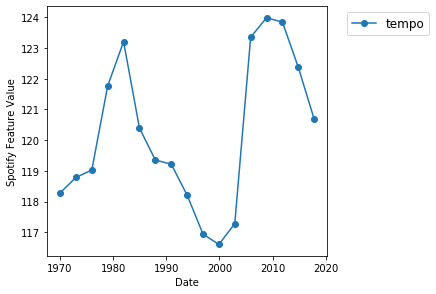

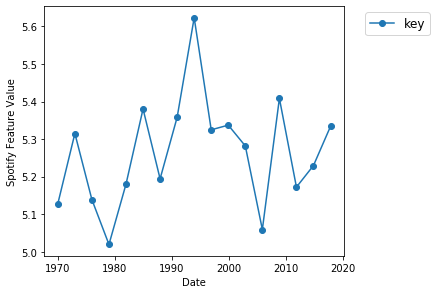

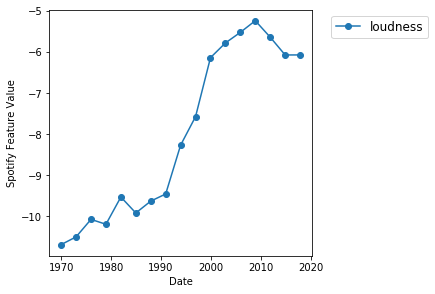

In [13]:
df = pickle.load(open('hot-100.df', 'rb')).reset_index()
plot_features(df, ['tempo'])
plot_features(df, ['key'])
plot_features(df, ['loudness'])

Over the last 50 years, we can see that the average tempo and key of popular music have oscillated, but remained near the same mean. Loudness, however, has been steadily increasing over time, peaking around 2010.

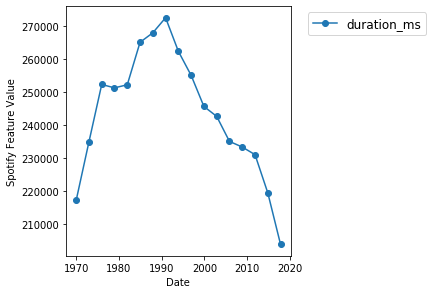

In [14]:
plot_features(df, ['duration_ms'])

However, the duration of songs spiked in the early 90s, before rapidly dropping back down. This is rather unexpected — it's interesting that music went from around 3:40 to 4:30, and then down to around 3:20.

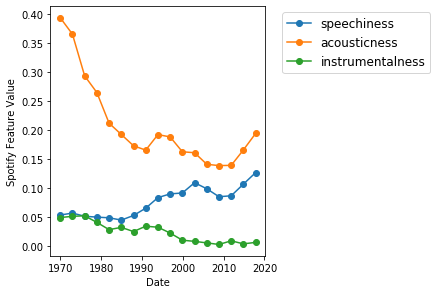

In [15]:
plot_features(df, ['speechiness','acousticness','instrumentalness'])

Now we start getting to the more interesting results. We can see that the speechiness of popular music has been steadily increasing, while the acousticness and instrumentalness has been decreasing. This could be explained by the increase in popularity of rap. Since rap has in general more spoken and fewer musical portions than other genres, such as rock, it could explain these findings.

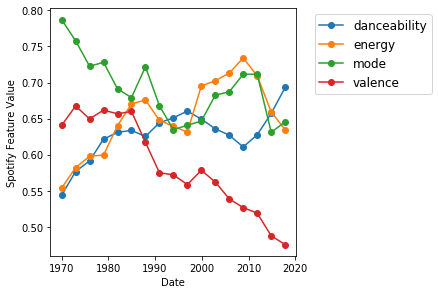

In [16]:
plot_features(df, ['danceability','energy','mode','valence'])

Here is another interesting plot. We can see that valence (happiness) has been largely decreasing since 1970. While this doesn't tell us anything about why, it's fascinating to note that music has been becoming less happy. Outside of a spike in the 2000s, the same is true of mode (modality, major or minor for a track).

On the flip side, music has ben generally been trending up both in energy and danceability, except in recent years.

### Genre Consistency
Given the above findings, we would like to investigate further to see if we can identify why music has trended the way it has. Perhaps popular genres have been changing or converging, which could explain the trends in indivual features. In order to answer this question,we will plot the feature distribution of top songs in each genre over time in order to see how the genres themselves have changed.

In [17]:
# radar.py and radar_factory are taken from https://matplotlib.org/3.1.0/gallery/specialty_plots/radar_chart.html
from radar import radar_factory
from numpy import random

features =['danceability', 'energy','mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence']

def get_grouped_chart(chart, weeksPerPoint=52):
    # Identify the features to plot and create aggregation functions
    aggregation_f = {'date': 'first'}

    for feature in features:
        aggregation_f[feature] = np.mean
    
    # Prepare the chart
    chart = chart.reset_index()
    chart['date'] = pd.to_datetime(chart['date'])
    grouped = chart.groupby('date')[features].agg(np.mean).reset_index()

    # Aggregate by the selected number of weeks
    sectionNum = []
    if weeksPerPoint > 1:
        num_sections = len(grouped) // weeksPerPoint
        for i in range(num_sections):
            sectionNum.extend([i]*weeksPerPoint)
        sectionNum.extend([num_sections]*(len(grouped) - num_sections*weeksPerPoint))
        grouped["section"] = sectionNum
        grouped = grouped.groupby('section').agg(aggregation_f).set_index('date')
    else:
        grouped = grouped.set_index('date')

    return grouped

def group_all_charts():
    charts = dict()
    for g in genres - {'hot-100'}:
        with open(g + '.df', 'rb') as f:
            chart = pickle.load(f)
        charts[g] = get_grouped_chart(chart)
    
    return charts

In [18]:
# Note that most genres have only 20 years of data
def plot_radars(num_graphs=4):
    interval = int(20 / num_graphs)
    
    charts = group_all_charts()

    # Create a plot for each time interval
    for i in range(2000, 2020, interval):
        N = len(features)
        theta = radar_factory(N, frame='polygon')
        data = []
        for _, chart in charts.items():
            genre = []
            for feature in features:
                v = chart[feature].loc['%d-01-01' % i:'%d-01-01' % (i+interval)].mean()
                genre.append(v)
            data.append(genre)

        spoke_labels = features
        fig = plt.figure()
        ax = fig.add_subplot(projection='radar')

        # Define colors and plot the four cases from the example data on separate axes
        colors = ['b', 'r', 'g', 'm', 'y', 'c', 'lime']
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title("Genres", weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        
        # Plot the data
        for d, color in zip(data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

        # add legend relative to top-left plot
        labels = charts.keys()
        plt.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
        plt.tight_layout()

        plt.show()

/Users/Niko/Desktop/CMU-Coursework/f19/15388/spotify_analysis/my_venv/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


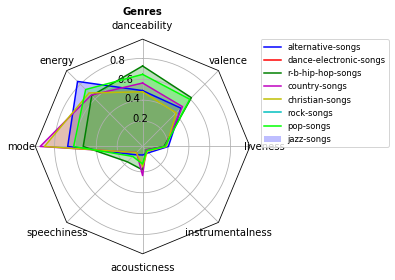

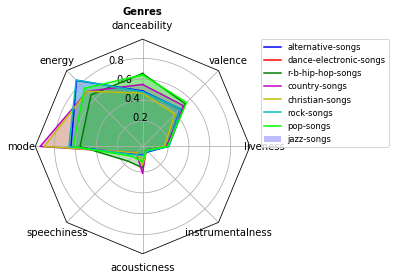

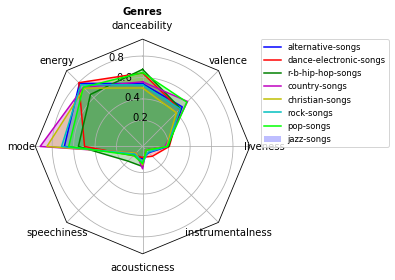

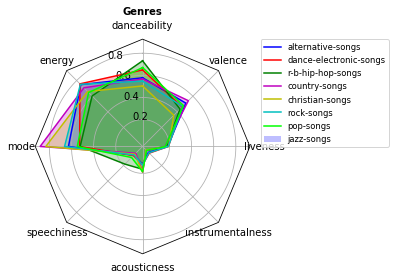

In [19]:
plot_radars(4)

As we can see from the above plots, genres have remained (fairly) consistent through the years. 

### Genre Distribution in Hot 100
It seems that changes within genres can't really explain the feature trends we saw earlier in the hot 100. Another thing we can consider is the popularity of genres at any given time. If the genre breakdown of the hot 100 changes over time, that could explain the feature trends.

To do this, we will analyze the intersection popular songs between a genre and the top 100 over time. Using this, we can see how genres have evolved closer together or further apart, and how genres have gained prevalence within popular music (Billboard Top 100)

In [20]:
from functools import reduce
# This function takes 2 datasets, and returns a set of points quantifying the number of overlapping songs

weeks_per_point = 53

def to_set(x):
    return set(x)

def prepare(df):
    # Turn the date index into a datetime object column
    df = df.reset_index()
    df['date'] = pd.to_datetime(df['date'])
    
    # Group the songs by the date they were popular and aggregate the IDs
    grouped = df.groupby('date')['id'].agg(to_set)

    # Aggregate the IDs into a smaller number of groups for easier comparison
    sections = []
    dates = []
    num_sections = len(grouped) // weeks_per_point
    for i in range(num_sections):
        dates += [grouped.reset_index()['date'][weeks_per_point * i]]
        if i + 1 == num_sections:
            sections += [list(grouped[weeks_per_point * i:])]
        else:
            sections += [list(grouped[weeks_per_point * i : weeks_per_point * (i + 1)])]
            
    # Combine the internal sets to make a list of sets
    sections = list(map(lambda a: reduce(lambda w,x: w.union(x), a), sections))
    
    # Clean the dates since we only care about the years
    dates = list(map(lambda a: a.to_pydatetime().year, dates))
    return dates, sections
    
def overlap(df1, df2):
    dates1, df1 = prepare(df1)
    dates2, df2 = prepare(df2)
    
    # Only consider overlapping data
    if len(dates1) < len(dates2):
        dates2 = dates2[-1 * len(dates1):]
        df2    =    df2[-1 * len(dates1):]
    elif len(dates2) < len(dates1):
        dates1 = dates1[-1 * len(dates2):]
        df1    =    df1[-1 * len(dates2):]

    # Count the overlap
    result = list(zip(df1, df2))
    result = list(map(lambda a: len(a[0].intersection(a[1])), result))

    return dates1, result

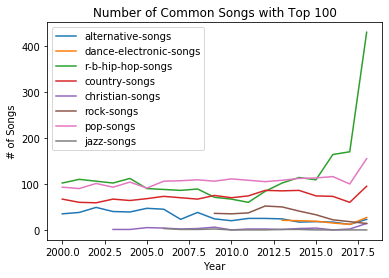

In [21]:
def plot_overlap():
    labels = genres - {'hot-100'}
    with open('hot-100.df', 'rb') as f:
        hot100 = pickle.load(f)

    for label in labels:
        with open(label + '.df', 'rb') as f:
            x, y = overlap(hot100, pickle.load(f))
            plt.plot(x,y)

    plt.legend(labels)
    plt.title('Number of Common Songs with Top 100')
    plt.xlabel('Year')
    plt.ylabel('# of Songs')
    plt.show()

plot_overlap()

One thing to note is that in this plot, the y axis represents the number of unique songs that overlap with the top 100 over the course of a year, which is why it comes out to over 100.

Now these are interesting results! We can see that pop and country have beocme more popular since around 2017, and hip hop has been on the rist since 2011, beginning to spike up in 2015. This could help explain the trends we saw in danceability, since hip hop songs are generally more danceable than rock or christian songs.

### Top Songs of All Time
Another interesting question to tackle is: what have been the most influential songs of all time? In order to answer this question, we will weight songs by the amount of time they spent in the hot 100, along with how high they were on the list.

In [40]:
def addWeights(df):
    # Define how features should aggregate
    aggregation_f = {'date': 'min', 'artist': 'first', 'name':'first', 'position':'sum'}
    
    # Invert position so that higher number signifies importance, and aggregate
    df['position'] = df['position'].apply(lambda x: 101-x)
    df = df.groupby(['name', 'artist']).agg(aggregation_f)

    return df

def getMostInfluentialSongs():
    with open('hot-100.df', 'rb') as f:
        hot = pickle.load(f)

    hot = addWeights(hot)
    hot = hot.sort_values('position', ascending=False)[['date', 'name', 'artist']]
    hot = hot.set_index('date')
    print(hot.head(10))

getMostInfluentialSongs()

                                     name  \
date                                        
2012-08-18                    radioactive   
1995-09-02  macarena - bayside boys remix   
1997-06-21                  how do i live   
1996-11-30                  foolish games   
2008-05-03                      i'm yours   
2011-02-12              party rock anthem   
2017-01-28                   shape of you   
2013-07-06                 counting stars   
2014-11-29                    uptown funk   
2010-12-25            rolling in the deep   

                                               artist  
date                                                   
2012-08-18                            imagine dragons  
1995-09-02                                los del rio  
1997-06-21                                leann rimes  
1996-11-30                                      jewel  
2008-05-03                                 jason mraz  
2011-02-12  lmfao featuring lauren bennett & goonrock  
2017-01-28 

This makes sense — a lot of these are songs that we've all heard of. However, it's interesting to note that a lot of the most influential songs seem to be newer songs. Let's investigate why this may be.

### Time Spent in Hot 100
To investigate this, we will look at the most popular songs (songs that hit the top 10), and see how long (on average) they spent in the top 100.

In [22]:
from statistics import mean

# Want the songs above top_cuttoff, and want to see how long they were in the top length_in
TOP_CUTTOFF = 10
LENGTH_IN = 100

# returns a dict mapping a year to a set of songs that were in the top n at some point that year
def get_uniques(top_df):
    topN = top_df[top_df['position'] <= TOP_CUTTOFF]
    uniques = topN.groupby(topN.date.dt.year)['name'].apply(set)

    return dict(uniques)

In [23]:
def song_count_top(top_df, song, year):
    result = top_df[top_df['date'].dt.year == year]
    result = result[result['name'] == song]
    result = result[result['position'] <= LENGTH_IN]
    return len(result)

def song_average_top(top_df, songs, year):
    total = 0
    for song in songs:
        total += song_count_top(top_df, song, year)
    
    return total / len(songs)

def yearly_average(top_df):    
    result = []
    uniques = get_uniques(top_df)
    
    for year, songs in uniques.items():
        avg = song_average_top(top_df, songs, year)
        result += [(year, avg)]

    return result

In [24]:
with open('hot-100.df', 'rb') as f:
    df = pickle.load(f)

df['date'] = pd.to_datetime(df['date'])
avg = yearly_average(df)

In [25]:
def divide_chunks(l, n):
    result = []
    for i in range(0, len(l), n):  
        if i >= len(l):
            result += [l[i:]]
        else:
            result += [l[i:i + n]]
    return result

def plot_avg(smoothing=1):
    years    = [elem[0] for elem in avg[::smoothing]]
    averages = [elem[1] for elem in avg]
    
    data = divide_chunks(averages, smoothing)
    data = list(map(mean, data))
    
    plt.plot(years, data)
    plt.xlabel('Year')
    plt.ylabel('Weeks')
    plt.title('Average Number of Weeks in Top %s' % LENGTH_IN)
    
    plt.show()

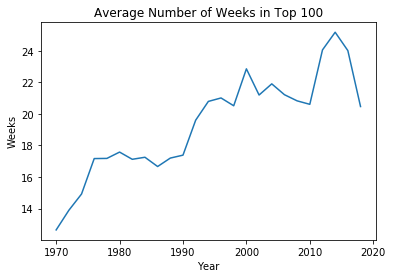

In [26]:
plot_avg(2)

As we can see, in on average, the amount of time popular songs spend in the top 100 has been increasing. Therefore it makes sense that the most popular songs of our data set came from more recent years.

### Analysis Conclusions
In conclusion, we can see that music is generally becoming louder and more danceable, but also sadder and less acoustic. Genres have remained fairly consistent, but the distribution of genres within the top 100 has begun to skew heavily towards hip hop. This may help to explain the trends in danceability and other features that we found. In addition, when songs become popular, they stay popular for longer than they used to. This could be due to any number of reasons, such as increased advertising to keep songs popular, larger consumption of media, less original music, etc. Further research would need to be done to help explain this trend.

## Machine Learning Model
TODO Joel